# In this example, we will rely on `pyjet` for jet clustering.

pyjet: https://github.com/scikit-hep/pyjet

In [5]:
import uproot
import pyjet
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import sys, os
import importlib
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm


## Define the class to fill particle information in to NumpyArray 

### User can use 
```
GenParticles = BrachGenParticles(file)
PID_all = GenParticles.PID
```
### to get all GenParticles PID array
### or
```
GenParticles = BrachGenParticles(file)
PID = GenParticles.PID_At(i)
```
### to get the GenParticles PID array in the ith event

In [2]:
class BrachGenParticles:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Particle.Status"].array())
        self.Status = file["Particle.Status"].array()
        self.PID = file["Particle.PID"].array()
        self.M1 = file["Particle.M1"].array()
        self.M2 = file["Particle.M2"].array()
        self.D1 = file["Particle.D1"].array()
        self.D2  = file["Particle.D2"].array()
        self.PT = file["Particle.PT"].array()
        self.Eta =  file["Particle.Eta"].array()
        self.Phi = file["Particle.Phi"].array()
        self.Mass = file["Particle.Mass"].array()
        self.Labels = ["Status", "PID" , "M1", "M2", "D1", "D2", "PT", "Eta", "Phi", "Mass"]
        
    def length_At(self, i):
        return len(self.Status[i])
    def Status_At(self, i):
        return self.Status[i]
    def PID_At(self, i):
        return self.PID[i]
    def M1_At(self, i):
        return self.M1[i]
    def M2_At(self, i):
        return self.M2[i]
    def D1_At(self, i):
        return self.D1[i]
    def D2_At(self, i):
        return self.D2[i]
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class BrachJet:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Jet.PT"].array())
        self.PT = file["Jet.PT"].array()
        self.Eta =  file["Jet.Eta"].array()
        self.Phi = file["Jet.Phi"].array()
        self.Mass = file["Jet.Mass"].array()
        
    def PT_At(self, i):
        return self.PT[i]
    def Eta_At(self, i):
        return self.Eta[i]
    def Phi_At(self, i):
        return self.Phi[i]
    def Mass_At(self, i):
        return self.Mass[i]
    
class Event_Weight:
    def __init__(self,file):
        self.file = file
        self.length = len(file["Event.Weight"].array())
        self.Event_Weight = np.array(file["Event.Weight"].array())
        
    def Event_Weight_At(self, i):
        return self.Event_Weight[i]

## Define Function for Invariant Mass, Transverse Mass

### NOTE: the MT formula here is not compatible with MT in the collider physics, please modify this formula by yourself.

In [3]:
def M(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
    
def MT(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), np.sqrt(m1**2+pt1**2)*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), np.sqrt(m2**2+pt2**2)*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    ET1, ET2  = np.sqrt(m1**2 + pt1**2), np.sqrt(m2**2 + pt2**2)
    MT = np.sqrt( (ET1+ET2)**2 - (px1+px2)**2 - (py1+py2)**2 )
    return MT
    
    

## Define Function for Check $r_{inv}$ and Preselection

In [4]:
def Check_r_inv(GenParticle):
    invis_count, vis_count = 0, 0
    Ndark = 0
    for i in range(GenParticle.length):
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            if (abs(PID) == 4900111) and (abs( GenParticle.PID_At(i)[D1]) != 4900111) and (abs( GenParticle.PID_At(i)[D2]) != 4900111):
                if (abs(GenParticle.PID_At(i)[D1]) != 3) and (abs( GenParticle.PID_At(i)[D2]) != 3):
                    invis_count += 1

            if (abs(PID) == 4900111) and (abs( GenParticle.PID_At(i)[D1]) != 4900111) and (abs( GenParticle.PID_At(i)[D2]) != 4900111):
                if (abs( GenParticle.PID_At(i)[D1]) == 3) or (abs( GenParticle.PID_At(i)[D2]) == 3):
                    vis_count += 1

            if (abs(PID) == 4900113) and (abs( GenParticle.PID_At(i)[D1]) != 4900113) and (abs( GenParticle.PID_At(i)[D2]) != 4900113):
                if (abs( GenParticle.PID_At(i)[D1]) > 490000) or (abs( GenParticle.PID_At(i)[D2]) > 490000):
                    invis_count += 1

            if (abs(PID) == 4900113) and (abs( GenParticle.PID_At(i)[D1]) != 4900113) and (abs( GenParticle.PID_At(i)[D2]) != 4900113):
                if (abs( GenParticle.PID_At(i)[D1]) < 6) or (abs( GenParticle.PID_At(i)[D2]) < 6):
                    vis_count += 1

            if (abs(PID) == 4900211) and (status == 1):
                    Ndark += 1

            if (abs(PID) == 4900213) and (status == 1):
                    Ndark += 1
    
    print("There are {} events.".format(len(GenParticle.Status)))
    print("There are Dark meson {}  decay into invisible particle.".format(invis_count))
    print("There are Dark meson {}  decay into visible particle.".format(vis_count))
    print("r_inv = {:^4.4f} ".format(invis_count/(invis_count+vis_count)))
    
    print("There are {} stable Dark mesons.".format(Ndark))
    print("Average = {:^4.4f} ".format(Ndark/len(GenParticle.Status)))
    
    return invis_count/(invis_count+vis_count), Ndark/len(GenParticle.Status)



def Find_xdxd(GenParticle):
    m_xdxd = []
    for i in range(GenParticle.length):
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            if PID == 4900101:
                tmp_1_pt = GenParticle.PT_At(i)[j]
                tmp_1_eta = GenParticle.Eta_At(i)[j]
                tmp_1_phi = GenParticle.Phi_At(i)[j]
                tmp_1_m = GenParticle.Mass_At(i)[j]
#                 print(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m)
                break
                
        for j in range(len(GenParticle.Status_At(i))):
            PID = GenParticle.PID_At(i)[j]
            M1 = GenParticle.M1_At(i)[j]
            M2 = GenParticle.M2_At(i)[j]
            D1 = GenParticle.D1_At(i)[j]
            D2 = GenParticle.D2_At(i)[j]
            status = GenParticle.Status_At(i)[j]
            
            
            if PID == -4900101:
                tmp_2_pt = GenParticle.PT_At(i)[j]
                tmp_2_eta = GenParticle.Eta_At(i)[j]
                tmp_2_phi = GenParticle.Phi_At(i)[j]
                tmp_2_m = GenParticle.Mass_At(i)[j]
#                 print(tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m)
                break
                
                
        m_xdxd.append(M(tmp_1_pt,tmp_1_eta,tmp_1_phi,tmp_1_m,tmp_2_pt,tmp_2_eta,tmp_2_phi,tmp_2_m))
        
    return np.array(m_xdxd)

    
def Preselection(Jet):
    twojet_invariantmass = []
    survived_list = []
    for i in range(Jet.length):
        if len(Jet.PT_At(i)) < 2:
            continue

#         if Jet.PT_At(i)[0] < 440 or Jet.PT_At(i)[1] < 60:
#             continue

#         if np.abs(Jet.Eta_At(i)[0]- Jet.Eta_At(i)[1]) > 1.2:
#             continue

        twojet_invariantmass.append(M(Jet.PT_At(i)[0],Jet.Eta_At(i)[0],Jet.Phi_At(i)[0],Jet.Mass_At(i)[0],
                                      Jet.PT_At(i)[1],Jet.Eta_At(i)[1],Jet.Phi_At(i)[1],Jet.Mass_At(i)[1]))

        survived_list.append(i)

    print("There are {} events.".format(len(twojet_invariantmass)))
    
    return np.array(twojet_invariantmass), np.array(survived_list)

## Import File

In [6]:
%%time
path = "/home/alan/MG5_Study_Group/tutorial/stable_dark_meson_decay_test"
SVJ_03_wo_decay_path = path + "/SVJ_03_wo_decay.root"
SVJ_03_w_decay_path = path + "/SVJ_03_w_decay.root"

SVJ_03_wo_decay = uproot.open(SVJ_03_wo_decay_path)["Delphes;1"]
SVJ_03_w_decay = uproot.open(SVJ_03_w_decay_path)["Delphes;1"]


CPU times: user 373 ms, sys: 13.3 ms, total: 386 ms
Wall time: 412 ms


#  Print the Branch in the Delphes

In [7]:
# file_3_5.show()

## Load event via class

In [8]:
%%time
GenParticle_3_5_wo_decay, Jet_3_5_wo_decay, Event_Weight_3_5_wo_decay = BrachGenParticles(SVJ_03_wo_decay), BrachJet(SVJ_03_wo_decay), Event_Weight(SVJ_03_wo_decay) 
GenParticle_3_5_w_decay, Jet_3_5_w_decay, Event_Weight_3_5_w_decay = BrachGenParticles(SVJ_03_w_decay), BrachJet(SVJ_03_w_decay), Event_Weight(SVJ_03_w_decay) 




CPU times: user 8.58 s, sys: 6.78 s, total: 15.4 s
Wall time: 15.6 s


# Select Stable Final State Particles

#### The `status` of stable final state particles in truth record is `1`.
#### We will loop over each event to build a `event_list` for final state particles.

In [12]:
%%time
print(time.strftime("%a %b %d %H:%M:%S %Y", time.localtime()))
time.sleep(0.5)
ticks_1 = time.time()

GenParticle = [GenParticle_3_5_wo_decay, GenParticle_3_5_w_decay]

event_list = [[],[]]

for i, element in enumerate(GenParticle):
    for N in tqdm(range(element.length)):
            
        event_list_tmp = []
        
        event_list_tmp.append([element.PT_At(N),  element.Eta_At(N), \
                               element.Phi_At(N), element.Mass_At(N), \
                               element.PID_At(N), element.Status_At(N),\
                              ])

        event_list_tmp = np.array(event_list_tmp)
        
        """
        Pick stable final state particel (status = 1) and filter ou neutrinos (|PID| = 12, 14, 16)
        """
        event_list_tmp = event_list_tmp[0][:,event_list_tmp[0][5,:]==1] 
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=12]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=14]
        event_list_tmp = event_list_tmp[:,np.abs(event_list_tmp[4,:])!=16]
        
        
        event_list[i].append(event_list_tmp)

#     if index == 1000:
#         break


print("There are {} events in this event list.".format(len(event_list[0])))
print("There are {} events in this event list.".format(len(event_list[1])))

ticks_2 = time.time()
totaltime =  ticks_2 - ticks_1
print("\033[3;33mTime Cost : {:.4f} min\033[0;m".format(totaltime/60.))

Mon Aug 09 10:08:26 2021


100%|██████████| 14613/14613 [00:02<00:00, 6521.12it/s]

There are 14676 events in this event list.
There are 14613 events in this event list.
Time Cost : 0.0710 min
CPU times: user 3.74 s, sys: 549 ms, total: 4.29 s
Wall time: 4.76 s


# Let's do jet clustering!!
### We use ` np.core.records.fromarrays` to assign the name of kinematic variables and PID
### In `pyjet`, the data type are only 
`
np.dtype([('pT', 'f8'), ('eta', 'f8'), ('phi', 'f8'), ('mass', 'f8')])
`
### or (cluster(..., ep=True))
`
np.dtype([('E', 'f8'), ('px', 'f8'), ('py', 'f8'), ('pz', 'f8')])  
`
### In this example, we use `(pt, eta, phi and mass)`.
### After assigning the name for our each event list, the `pyjet.cluster` and `inclusive_jets` will help us do jet clustering.
`
sequence_cluster = pyjet.cluster(to_cluster, R = 0.4,p = -1)
jets_cluster = sequence_cluster.inclusive_jets(pt_min)
`
#### Variable: `R` is the cone size of the jet.
#### Variable: `p` is the jet clustering algorithm. `-1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt`
#### Variable: `pt_min` is the minimum jet's pt.



In [53]:
%%time
event_list_clustered = [[],[]]
for i, event in enumerate(event_list):
    for element in tqdm(event):
        to_cluster = np.core.records.fromarrays(element, 
                                                     names="pT, eta, phi, mass, PID, status",
                                                     formats = "f8, f8, f8, f8, f8, f8")
        pt_min = 200
        sequence_cluster = pyjet.cluster(to_cluster, R = 0.4, p = -1) # p = -1: anti-kt , 0: Cambridge-Aachen(C/A), 1: kt
        jets_cluster = sequence_cluster.inclusive_jets(pt_min)
        event_list_clustered[i].append(jets_cluster)


100%|██████████| 14613/14613 [01:22<00:00, 176.96it/s]

CPU times: user 2min 32s, sys: 2.09 s, total: 2min 34s
Wall time: 2min 32s


# Print jets in the Nth event

In [ ]:
N = 2

for i, jets in enumerate(event_list_clustered[1][N]):
    print("{}".format("No." +str(i)+" Jet's Information"))
    print(jets)
    print("-------------------------------------------------------------------------")
    print("{:^19} {:^20} ".format("Constituent's PID","Constituent's Four Momentum"))
    print("-------------------------------------------------------------------------")
    
    for constituent in jets: # get constituent in each "jet_element"
        print("{:^19} {} ".format(int(constituent.PID), constituent))
    print("-------------------------------------------------------------------------")

# Print the Truth Record in an Event

In [ ]:
GenParticle = GenParticle_3_5_w_decay
# GenParticle = GenParticle_ppzjj
print("There are {} information in this event.".format(len(GenParticle.Status[0])))
print("GenParticle Information")
print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8}{:^8}{:^8}{:^8}".format("#","Status","PID", "M1", "M2", "D1", "D2", "PT", "Eta","Phi", "Mass"))

index = 0 ## which event you want to print out

for j in range(len(GenParticle.Status_At(index))):
    
    if GenParticle.Status_At(index)[j] == 1: ##Selet the Stable Final State Particles

        print("{:^5}{:^7}{:^7}{:^7}{:^7}{:^7}{:^7}{:^8.5}{:^8.5}{:^8.5}{:^8.5}".format( \
        j, GenParticle.Status_At(index)[j],  GenParticle.PID_At(index)[j], GenParticle.M1_At(index)[j], GenParticle.M2_At(index)[j],
         GenParticle.D1_At(index)[j], GenParticle.D2_At(index)[j],  GenParticle.PT_At(index)[j],  GenParticle.Eta_At(index)[j], GenParticle.Phi_At(index)[j], GenParticle.Mass_At(index)[j]))



# Calculate di-jet Inavariant Mass from Detector Simulation

In [65]:
%%time
dijet_invariantmass_wo_decay, survived_list_wo_decay = Preselection(Jet_3_5_wo_decay)
dijet_invariantmass_w_decay, survived_list_w_decay = Preselection(Jet_3_5_w_decay)



There are 2937 events.
There are 10608 events.
CPU times: user 1.79 s, sys: 0 ns, total: 1.79 s
Wall time: 1.79 s


## Calculate the number of event for event weight 
## Luminosity $\mathcal{L}$  = 37 $fb^{-1}$

In [66]:
weight_03_5_wo_decay = Event_Weight_3_5_wo_decay.Event_Weight/20000
weight_03_5_w_decay = Event_Weight_3_5_w_decay.Event_Weight/20000

# Di-Jet Events' Selection From Truth Record
### We want to compare the inavriant mass distribution between two reconstructed jets and two dark quarks.
### We need select the events with # of jet >=2.

In [132]:
%%time
M_JJ = [[],[]]
event_sele = [[],[]]
for i, element in enumerate(event_list_clustered):
    for N in range(len(element)):

        if len(element[N]) >= 2: # at least two jets in this event.
            jet_1 = element[N][0] #leading jet's information
            jet_2 = element[N][1] #subleading jet's information

            M_JJ[i].append( M(jet_1.pt,jet_1.eta,jet_1.phi,jet_1.mass,jet_2.pt,jet_2.eta,jet_2.phi,jet_2.mass))
            event_sele[i].append(N)
        
print("There are {} events passed this di-jet selection.".format(len(M_JJ[0])))
print("There are {} events passed this di-jet selection.".format(len(M_JJ[1])))

There are 12365 events passed this di-jet selection.
There are 12175 events passed this di-jet selection.
CPU times: user 715 ms, sys: 0 ns, total: 715 ms
Wall time: 712 ms


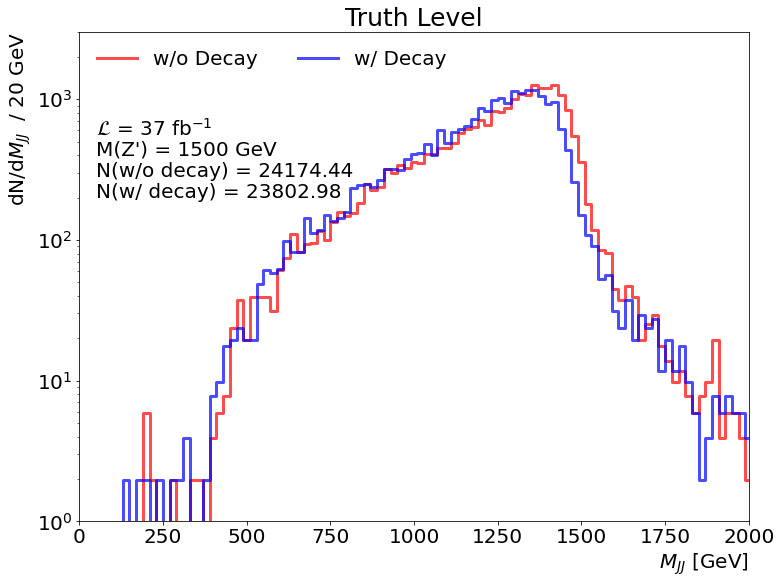

In [133]:
plt.figure(figsize=(12,9)) # plotsize


bin_size = np.linspace(0,5000,251)


hist_M_JJ_wo_decay, bins_M_JJ_wo_decay = np.histogram(M_JJ[0], bins=bin_size, weights = weight_03_5_wo_decay[event_sele[0]]*37*2000)
plt.step(bins_M_JJ_wo_decay[:-1], hist_M_JJ_wo_decay.astype(np.float32), color = "red", where='mid',linewidth=3, alpha=0.7,label="w/o Decay") 


hist_M_JJ_w_decay, bins_M_JJ_w_decay = np.histogram(M_JJ[1], bins=bin_size, weights = weight_03_5_w_decay[event_sele[1]]*37*2000)
plt.step(bins_M_JJ_w_decay[:-1], hist_M_JJ_w_decay.astype(np.float32), color = "blue", where='mid',linewidth=3, alpha=0.7,label="w/ Decay") 

plt.title("Truth Level", fontsize=25)


plt.text(50, 550, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(50, 400, "M(Z') = 1500 GeV", fontsize=20)
plt.text(50, 280, "N(w/o decay) = " + str(np.round(np.sum(hist_M_JJ_wo_decay.astype(np.float32)),2)), fontsize=20)
plt.text(50, 200, "N(w/ decay) = " + str(np.round(np.sum(hist_M_JJ_w_decay.astype(np.float32)),2)), fontsize=20)


plt.legend(loc="upper left",ncol=2,fontsize=20,frameon=False)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("$M_{JJ}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("dN/d$M_{JJ}$  / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((1,3000))
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

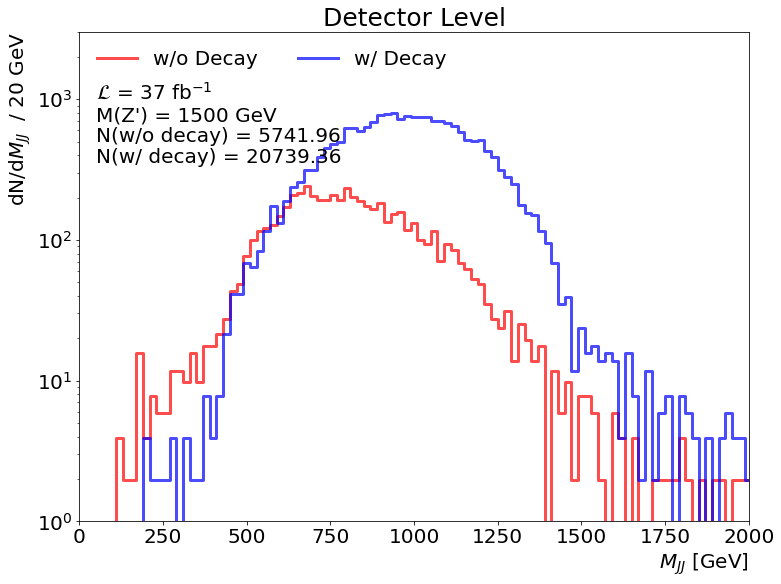

In [134]:
plt.figure(figsize=(12,9)) # plotsize


bin_size = np.linspace(0,5000,251)


hist_M_JJ_wo_decay, bins_M_JJ_wo_decay = np.histogram(dijet_invariantmass_wo_decay, bins=bin_size, weights = weight_03_5_wo_decay[survived_list_wo_decay]*37*2000)
plt.step(bins_M_JJ_wo_decay[:-1], hist_M_JJ_wo_decay.astype(np.float32), color = "red", where='mid',linewidth=3, alpha=0.7,label="w/o Decay") 


hist_M_JJ_w_decay, bins_M_JJ_w_decay = np.histogram(dijet_invariantmass_w_decay, bins=bin_size, weights = weight_03_5_w_decay[survived_list_w_decay]*37*2000)
plt.step(bins_M_JJ_w_decay[:-1], hist_M_JJ_w_decay.astype(np.float32), color = "blue", where='mid',linewidth=3, alpha=0.7,label="w/ Decay") 

plt.title("Detector Level", fontsize=25)


plt.text(50, 1000, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(50, 700, "M(Z') = 1500 GeV", fontsize=20)
plt.text(50, 500, "N(w/o decay) = " + str(np.round(np.sum(hist_M_JJ_wo_decay.astype(np.float32)),2)), fontsize=20)
plt.text(50, 350, "N(w/ decay) = " + str(np.round(np.sum(hist_M_JJ_w_decay.astype(np.float32)),2)), fontsize=20)


plt.legend(loc="upper left",ncol=2,fontsize=20,frameon=False)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("$M_{JJ}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("dN/d$M_{JJ}$  / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((1,3000))
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()

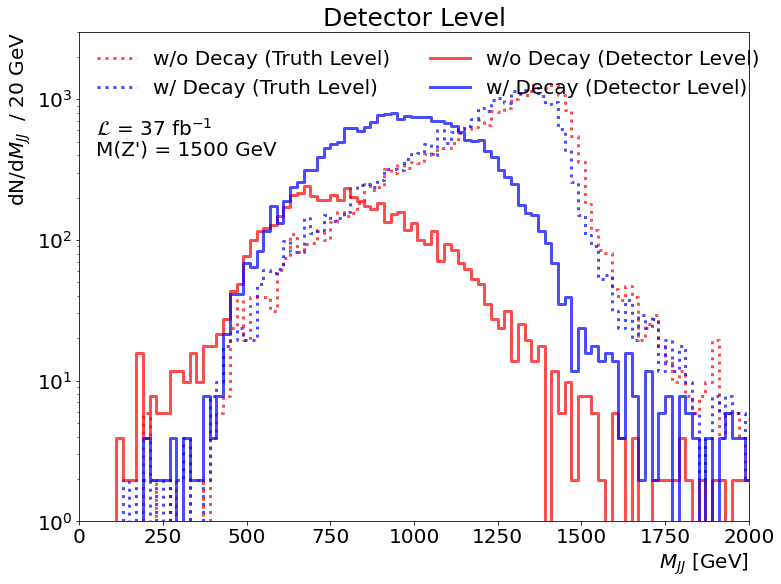

In [137]:
plt.figure(figsize=(12,9)) # plotsize


bin_size = np.linspace(0,5000,251)


"truth level"
hist_M_JJ_wo_decay, bins_M_JJ_wo_decay = np.histogram(M_JJ[0], bins=bin_size, weights = weight_03_5_wo_decay[event_sele[0]]*37*2000)
plt.step(bins_M_JJ_wo_decay[:-1], hist_M_JJ_wo_decay.astype(np.float32), linestyle=":", color = "red", where='mid',linewidth=3, alpha=0.7,label="w/o Decay (Truth Level)") 


hist_M_JJ_w_decay, bins_M_JJ_w_decay = np.histogram(M_JJ[1], bins=bin_size, weights = weight_03_5_w_decay[event_sele[1]]*37*2000)
plt.step(bins_M_JJ_w_decay[:-1], hist_M_JJ_w_decay.astype(np.float32), linestyle=":", color = "blue", where='mid',linewidth=3, alpha=0.7,label="w/ Decay (Truth Level)") 


"detector level"
hist_M_JJ_wo_decay, bins_M_JJ_wo_decay = np.histogram(dijet_invariantmass_wo_decay, bins=bin_size, weights = weight_03_5_wo_decay[survived_list_wo_decay]*37*2000)
plt.step(bins_M_JJ_wo_decay[:-1], hist_M_JJ_wo_decay.astype(np.float32), color = "red", where='mid',linewidth=3, alpha=0.7,label="w/o Decay (Detector Level)") 


hist_M_JJ_w_decay, bins_M_JJ_w_decay = np.histogram(dijet_invariantmass_w_decay, bins=bin_size, weights = weight_03_5_w_decay[survived_list_w_decay]*37*2000)
plt.step(bins_M_JJ_w_decay[:-1], hist_M_JJ_w_decay.astype(np.float32), color = "blue", where='mid',linewidth=3, alpha=0.7,label="w/ Decay (Detector Level)") 

plt.title("Detector Level", fontsize=25)


plt.text(50, 550, "$\mathcal{L}$ = 37 $\mathrm{fb}^{-1}$", fontsize=20)
plt.text(50, 400, "M(Z') = 1500 GeV", fontsize=20)
# plt.text(50, 280, "N(w/o decay) = " + str(np.round(np.sum(hist_M_JJ_wo_decay.astype(np.float32)),2)), fontsize=20)
# plt.text(50, 200, "N(w/ decay) = " + str(np.round(np.sum(hist_M_JJ_w_decay.astype(np.float32)),2)), fontsize=20)


plt.legend(loc="upper left",ncol=2,fontsize=20,frameon=False)
# plt.legend(ncol=2,fontsize=25)# plot label tag
plt.yscale('log') 
# plt.xscale('log') 
plt.xlabel("$M_{JJ}$ [GeV]" , fontsize=20, horizontalalignment='right',x=1)  # plot x-axis label
plt.ylabel("dN/d$M_{JJ}$  / 20 GeV ", fontsize=20, horizontalalignment='right',y=1)  # plot y-axis label
plt.xticks(fontsize=20)   # set x-ticks size
plt.yticks(fontsize=20)   # set y-ticks size 
plt.xlim((0,2000))
plt.ylim((1,3000))
# plt.savefig("./invariant_mass_SVJ.png")  #save figure as png
plt.show()